In [1]:
import os, sys
import geopandas as gpd
import pandas as pd
import rasterio as rio
import numpy as np
from shapely.geometry import Point
import skimage.graph as graph
from glob import glob
import matplotlib.ticker as mtick


In [2]:
sys.path.append('/home/wb514197/Repos/gostrocks/src') # gostrocks is used for some basic raster operations (clip and standardize)
sys.path.append('/home/wb514197/Repos/GOSTNets_Raster/src') # gostnets_raster has functions to work with friction surface
sys.path.append('/home/wb514197/Repos/GOSTnets') # it also depends on gostnets for some reason
sys.path.append('/home/wb514197/Repos/INFRA_SAP') # only used to save some raster results
# sys.path.append('/home/wb514197/Repos/HospitalAccessibility/src') # only used to save some raster results

In [52]:
import GOSTRocks.rasterMisc as rMisc
import GOSTNetsRaster.market_access as ma
from infrasap import aggregator
from rasterstats import zonal_stats
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
sns.set()

In [4]:
iso3 = 'LBR'

In [5]:
input_dir = "/home/public/Data/PROJECTS/Health" #
out_folder = os.path.join(input_dir, "output", iso3)
if not os.path.exists(out_folder):
    os.mkdir(out_folder)

In [6]:
out_pop_surface_std = os.path.join(out_folder, "WP_2020_1km_STD.tif")

In [7]:
# create a data frame of all points
pop_surf = rio.open(out_pop_surface_std)
pop = pop_surf.read(1, masked=True)
# indices = list(np.ndindex(pop.shape))
# xys = [Point(pop_surf.xy(ind[0], ind[1])) for ind in indices]
# res_df = pd.DataFrame({
#     'spatial_index': indices, 
#     'xy': xys, 
#     'pop': pop.flatten()
# })
# res_df['pointid'] = res_df.index

In [8]:
global_admin2 = '/home/public/Data/GLOBAL/ADMIN/Admin2_Polys.shp'
adm2 = gpd.read_file(global_admin2)
adm2 = adm2.loc[adm2.ISO3==iso3].copy()
adm2 = adm2.to_crs("EPSG:4326")
adm2.reset_index(inplace=True, drop=True)

In [57]:
global_admin1 = '/home/public/Data/GLOBAL/ADMIN/Admin1_Polys.shp'
adm1 = gpd.read_file(global_admin1)
adm1 = adm1.loc[adm1.ISO3==iso3].copy()
adm1 = adm1.to_crs("EPSG:4326")
adm1.reset_index(inplace=True, drop=True)

In [100]:
global_admin0 = '/home/public/Data/GLOBAL/ADMIN/g2015_0_simplified.shp'
adm0 = gpd.read_file(global_admin0)
adm0 = adm0.loc[adm0.ISO3166_1_==iso3].copy()
adm0 = adm0.to_crs("EPSG:4326")
adm0.reset_index(inplace=True, drop=True)

<AxesSubplot:>

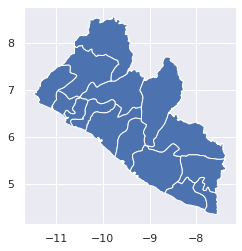

In [59]:
adm1.plot()

In [60]:
tt_path = os.path.join(out_folder, 'tt_rasters')

In [84]:
# glob(tt_path+"/tt_offer*")
files = [os.path.join(tt_path, f) for f in os.listdir(tt_path) if 'offer' in f]

In [241]:
res = pd.DataFrame(zonal_stats(adm1, pop.filled(), affine=pop_surf.transform, stats='sum', nodata=pop_surf.nodata)).rename(columns={'sum':'pop'})

In [242]:
files

['/home/public/Data/PROJECTS/Health/output/LBR/tt_rasters/tt_offer_emonc.tif',
 '/home/public/Data/PROJECTS/Health/output/LBR/tt_rasters/tt_offer_childimmune.tif',
 '/home/public/Data/PROJECTS/Health/output/LBR/tt_rasters/tt_offer_anc.tif',
 '/home/public/Data/PROJECTS/Health/output/LBR/tt_rasters/tt_offer_adolescentsrhr.tif',
 '/home/public/Data/PROJECTS/Health/output/LBR/tt_rasters/tt_offer_essentialnutrition.tif']

In [243]:
for f in files:
    service = f.split("_")[-1].strip('.tif')
    tt_rio = rio.open(f)
    tt = tt_rio.read(1, masked=True)
    pop_120 = pop*(tt>120)
    zs = pd.DataFrame(zonal_stats(adm1, pop_120.filled(), affine=pop_surf.transform, stats='sum', nodata=pop_surf.nodata)).rename(columns={'sum':f'{service}'})
    res = res.join(zs)

In [244]:
# res.sort_values('pop_120_essentialnutrition', ascending=False, inplace=True)

In [245]:
# df = res.head(10).iloc[:, 1:4].copy()
# df = res.head(10)
df = res.copy()

In [246]:
df.reset_index(inplace=True)

In [247]:
df.head(2)

,index,pop,emonc,childimmune,anc,adolescentsrhr,essentialnutrition
0,0,152888.479056,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,370047.514226,14067.058102,13629.488738,13629.488738,14375.905726,15095.827163


In [248]:
# df = adm2[['WB_ADM2_NA']].join(df)
df = adm1[['WB_ADM1_NA']].join(df)

In [249]:
df.head(2)

,WB_ADM1_NA,index,pop,emonc,childimmune,anc,adolescentsrhr,essentialnutrition
0,Bomi,0,152888.479056,0.000000,0.000000,0.000000,0.000000,0.000000
1,Bong,1,370047.514226,14067.058102,13629.488738,13629.488738,14375.905726,15095.827163


In [250]:
# df = pd.melt(df, id_vars=['index', 'pop'], var_name='service', value_name='pop_exc')
df = pd.melt(df, id_vars=['index', 'WB_ADM1_NA', 'pop'], var_name='service', value_name='pop_exc')
# df = pd.melt(df, id_vars=['index', 'WB_ADM2_NA', 'pop'], var_name='service', value_name='pop_exc')

In [251]:
df.head(2)

,index,WB_ADM1_NA,pop,service,pop_exc
0,0,Bomi,152888.479056,emonc,0.000000
1,1,Bong,370047.514226,emonc,14067.058102


In [252]:
df.loc[:, 'pop_exc_pct'] = df['pop_exc'] / df['pop']

In [253]:
sns.set(font_scale = 1)
sns.set_style("whitegrid")

In [254]:
# fig, ax = plt.subplots(figsize=(24, 6))
# ax = sns.barplot(x="WB_ADM1_NA", y="pop_exc", hue="service", data=df)

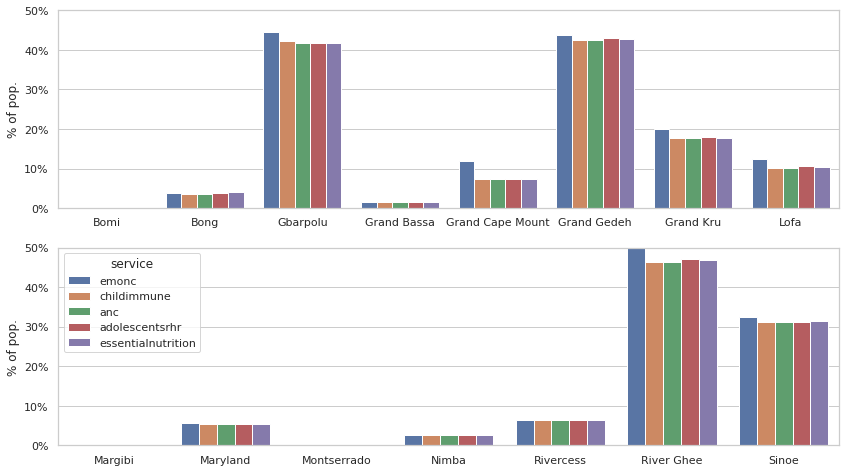

In [255]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(14,8))
sns.barplot(ax = ax1, x="WB_ADM1_NA", y="pop_exc_pct", hue="service", data=df.loc[df['index']<8])
sns.barplot(ax = ax2, x="WB_ADM1_NA", y="pop_exc_pct", hue="service", data=df.loc[df['index']>=8])
ax1.set(xlabel="", ylabel="% of pop.")
ax2.set(xlabel="", ylabel="% of pop.")
ax1.set_ylim(0, 0.5)
ax2.set_ylim(0, 0.5)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax1.legend([],[], frameon=False)
# plt.savefig("./adm1_service.png", facecolor='white', dpi=300)